In [1]:
%pylab inline
import cv2
import imutils
from imutils import contours
import matplotlib.patches as patches
import pytesseract
import zbar
import labelreader
import skimage.morphology

Populating the interactive namespace from numpy and matplotlib


In [2]:
# 64
image = cv2.imread("haar_classifier/new_supermarket_photos/spar_results/ok/64.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
grad = labelreader.imageGrads(gray)
borders, borderCnts = labelreader.imageBordersHough(grad)
objgrad = labelreader.imageObjgrad(grad, borders)
cnts = labelreader.imageContours(objgrad)
boxes = labelreader.imageBoxes(objgrad)
lines = labelreader.imageLines(boxes)
lineboxes = labelreader.lineBoxes(lines, boxes)
linetexts = ["" for b in lineboxes]
#linetexts = labelreader.imageTexts(gray, lineboxes, vmargin=2, hmargin=2)
#print [(txt, b)
#        for txt, b in zip(linetexts, lineboxes)
#        if txt]

/home/redhog/Projects/innovationgarage/price-tag-reader/env/local/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


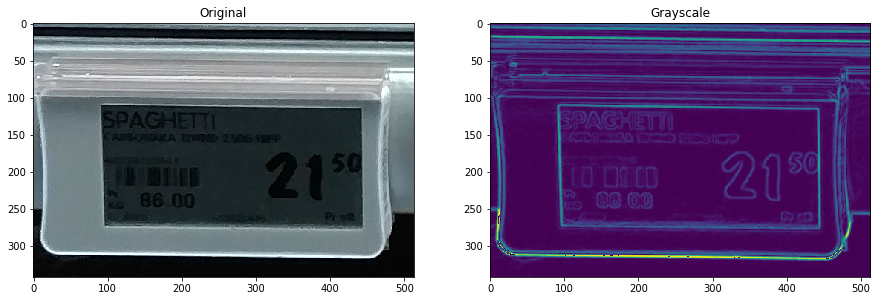

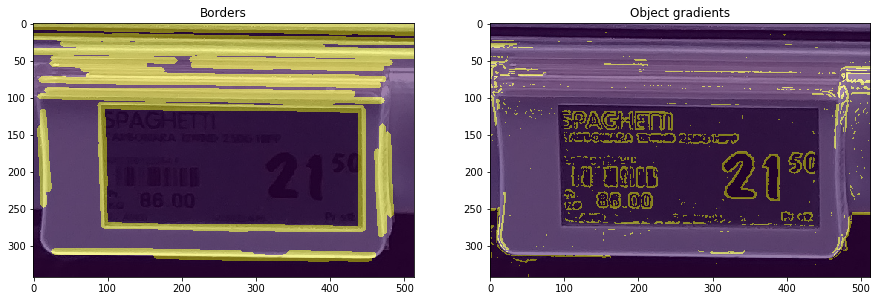

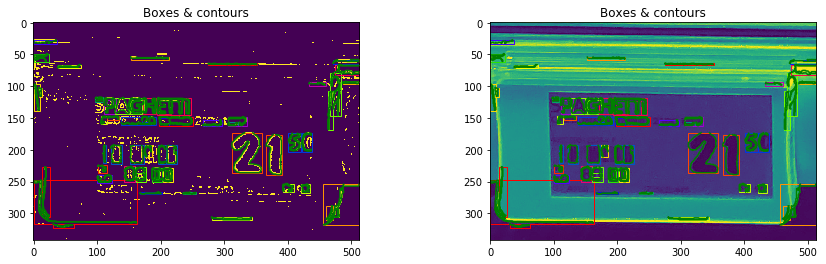

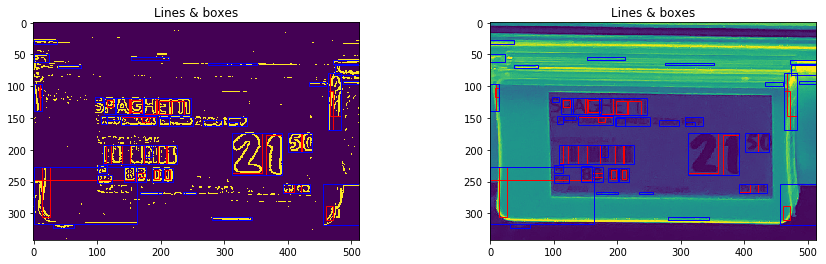

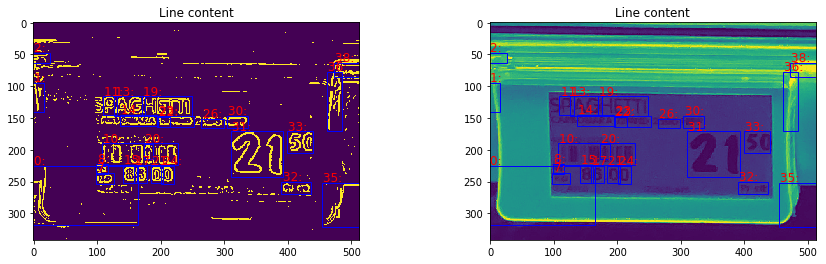

In [3]:
fig = plt.figure(); fig, axs = plt.subplots(1,2, figsize=(15,5)); axs = axs.flatten()
axs[0].imshow(image); axs[0].set_title('Original')
axs[1].imshow(gray); axs[1].set_title('Grayscale')
fig.show()

plt.imshow(grad)
plt.show()

fig = plt.figure(); fig, axs = plt.subplots(1,2, figsize=(15,5)); axs = axs.flatten()
axs[0].imshow(image, alpha=1); axs[0].imshow(borders, alpha=0.5); axs[0].set_title('Borders')
axs[1].imshow(image, alpha=1); axs[1].imshow(objgrad, alpha=0.5); axs[1].set_title('Object gradients')
fig.show()

fig, axs = plt.subplots(1,2, figsize=(15,4))
axs = axs.flatten()
axs[0].imshow(objgrad); axs[0].set_title('Boxes & contours')
axs[1].imshow(gray); axs[1].set_title('Boxes & contours')
for idx in (0, 1):
    labelreader.drawCountours(axs[idx], cnts)
    labelreader.drawLines(axs[idx], lines, boxes)
fig.show()


fig, axs = plt.subplots(1,2, figsize=(15,4))
axs = axs.flatten()
axs[0].imshow(objgrad); axs[0].set_title('Lines & boxes')
axs[1].imshow(gray); axs[1].set_title('Lines & boxes')
for idx in (0, 1):
    labelreader.drawLineParts(axs[idx], lines, boxes)
    labelreader.drawLineBoxes(axs[idx], lineboxes)
    fig.show()
    
        
fig, axs = plt.subplots(1,2, figsize=(15,4))
axs = axs.flatten()
axs[0].imshow(objgrad); axs[0].set_title('Line content')
axs[1].imshow(gray); axs[1].set_title('Line content')
for idx in (0, 1):
    labelreader.drawLineBoxesAndText(axs[idx], lineboxes, linetexts, vmargin=2, hmargin=2)
    fig.show()